0826_(1)에서 valid patience 부분을 추가함
acc:63.52, f1:0.49

## 0. Libarary 불러오기 및 경로설정

In [2]:
import os
import pandas as pd
from PIL import Image
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

from torchvision import models
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, CenterCrop

In [3]:
train_dir = '/opt/ml/input/data/train'

## 2. Train Dataset 정의

In [4]:
class TrainDataset(Dataset):
    def __init__(self,img_paths,labels,trans_dict,val=False):
        self.img_paths = img_paths
        self.labels = labels
        self.trans_dict = trans_dict
        self.val = val
        
    def __getitem__(self,index):
        image = Image.open(self.img_paths[index])
        label = self.labels[index]
        if self.trans_dict:
            if self.val:
                image = self.trans_dict['val'](image)
            elif label in [0,1,3,4]:
                image = self.trans_dict['train1'](image)
            else:
                image = self.trans_dict['train2'](image)
        
        return image,label

    def __len__(self):
        return len(self.img_paths)

## 3. DataLoader 정의

sample 이미지 살펴보고 transform 결정

4


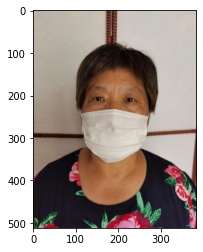

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

image = Image.open(image_paths[47])
print(labels[47])
plt.imshow(image)

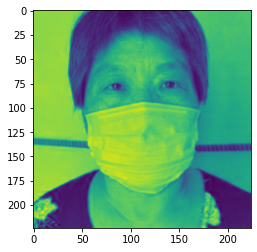

In [15]:
image2 = data_transform['train2'](image)
plt.imshow(image2[0])

In [16]:
#hyperparam 정의
num_epoch = 20
num_classes = 18
batch_size = 64
val_split = 0.2
random_seed= 48
shuffle_dataset = True

In [18]:
# meta 데이터와 이미지 경로를 불러옵니다.
train_info = pd.read_csv(os.path.join(train_dir, 'train3.csv'))
image_paths = train_info['path']
labels = train_info['category']

#transform 정의
data_transform = {
    'train1': transforms.Compose([
                CenterCrop(300),  
                Resize((224, 224)),
                transforms.RandomHorizontalFlip(p=0.5),
                ToTensor(),
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
            ]),
    'train2': transforms.Compose([
                    CenterCrop(300),  
                    Resize((224, 224)),
                    transforms.RandomHorizontalFlip(p=0.5),
                    transforms.RandomApply(transforms=[transforms.ColorJitter(0.5,0.1,0.1,0.1)],p=0.5),
                    #transforms.RandomApply(transforms=[transforms.Pad(padding=5, fill=0, padding_mode='constant')],p=0.5),
                    transforms.RandomApply(transforms=[transforms.RandomPerspective(distortion_scale=0.2, p=0.5)],p=0.5),
                    ToTensor(),
                    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2))
                ]),
    'val': transforms.Compose([
                Resize((224, 224), Image.BILINEAR),
                ToTensor(),
                Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
            ])
}

#train val split
dataset_size = len(labels)
indices = list(range(dataset_size))
split = int(np.floor(val_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_dataset = TrainDataset(list(image_paths[train_indices]),list(labels[train_indices]),data_transform)
val_dataset = TrainDataset(list(image_paths[val_indices]),list(labels[val_indices]),data_transform,val=True)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    drop_last=True
)
print(len(train_dataset),len(val_dataset),dataset_size)

15120 3780 18900


## 4. Model 정의

In [19]:
from custom_models import ResnetModel as MyModel

## 5. Train

In [21]:
from sklearn.metrics import f1_score
import numpy as np
from loss import f1_loss

# 모델을 정의
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MyModel(num_classes=num_classes).to(device)


#loss function, optimizer 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

#모델 학습
from tqdm import tqdm
right_count = [0 for _ in range(num_classes)]
wrong_count = [0 for _ in range(num_classes)]

temp_valid_f1=0.0; patience=0

for epoch in tqdm(range(num_epoch)):
    #train
    model.train()
    cur_loss,cur_acc,cur_f1 = 0.0,0.0,0.0
    for i,data in enumerate(train_dataloader):
        images,labels = data
        images,labels = images.to(device),labels.to(device)
        
        optimizer.zero_grad()
        model_output = model(images)
        loss = criterion(model_output,labels)
        loss.backward()
        optimizer.step()
        
        cur_loss += loss.item()
        
        predict = model_output.argmax(dim=-1)
        cur_acc += torch.sum(labels==predict)
        
        f1 = f1_loss(labels,model_output)
        cur_f1 += f1
                
        for k in range(batch_size):
            if predict[k]==labels[k]: right_count[labels[k]]+=1
            else: wrong_count[labels[k]]+=1
        
        if i%100==99:
            print('[%d,%5d] train_loss: %.3f, train_acc:%.3f, train_f1:%.3f'% (epoch+1,i+1,cur_loss/100,cur_acc/(batch_size*100),cur_f1/100))
            cur_loss,cur_acc,cur_f1 = 0.0,0.0,0.0
        
    #eval
    model.eval()
    valid_loss,valid_acc,valid_f1=0.0,0.0,0.0
    for i,data in enumerate(val_dataloader):
        images,labels = data
        images,labels = images.to(device),labels.to(device)
        
        model_output = model(images)
        #print(model_output,labels)
        loss = criterion(model_output,labels)
        valid_loss += loss.item()
        
        predict = model_output.argmax(dim=-1)
        valid_acc += torch.sum(labels==predict)
        
        f1 = f1_loss(labels,model_output)
        valid_f1 += f1
    print('epoch [%d] valid_loss: %.3f, valid_acc:%.3f, valid_f1:%.3f'% (epoch+1,valid_loss/(i+1),valid_acc/(16*(i+1)),valid_f1/(i+1)))
    patience = patience+1 if valid_f1 < temp_valid_f1 else 0
    if patience>=3: 
        torch.save(model,'..models/0826_3_model.pth')
        break
    temp_valid_f1 = valid_f1
    
print('training finished')

  0%|          | 0/20 [00:00<?, ?it/s]

[1,  100] train_loss: 1.969, train_acc:0.406, train_f1:5.698
[1,  200] train_loss: 1.400, train_acc:0.592, train_f1:8.119


  5%|▌         | 1/20 [02:24<45:48, 144.64s/it]

epoch [1] valid_loss: 1.297, valid_acc:0.637, valid_f1:8.164
[2,  100] train_loss: 1.125, train_acc:0.661, train_f1:8.561
[2,  200] train_loss: 1.055, train_acc:0.690, train_f1:8.694


 10%|█         | 2/20 [04:55<43:56, 146.47s/it]

epoch [2] valid_loss: 1.095, valid_acc:0.684, valid_f1:8.358
[3,  100] train_loss: 0.949, train_acc:0.712, train_f1:8.753
[3,  200] train_loss: 0.928, train_acc:0.717, train_f1:8.786


 15%|█▌        | 3/20 [07:36<42:44, 150.84s/it]

epoch [3] valid_loss: 1.002, valid_acc:0.702, valid_f1:8.362
[4,  100] train_loss: 0.855, train_acc:0.742, train_f1:8.795
[4,  200] train_loss: 0.847, train_acc:0.750, train_f1:8.853


 20%|██        | 4/20 [09:50<38:53, 145.83s/it]

epoch [4] valid_loss: 0.947, valid_acc:0.715, valid_f1:8.417
[5,  100] train_loss: 0.806, train_acc:0.750, train_f1:8.829
[5,  200] train_loss: 0.804, train_acc:0.760, train_f1:8.880


 25%|██▌       | 5/20 [12:16<36:27, 145.86s/it]

epoch [5] valid_loss: 0.904, valid_acc:0.721, valid_f1:8.451
[6,  100] train_loss: 0.762, train_acc:0.762, train_f1:8.873
[6,  200] train_loss: 0.772, train_acc:0.763, train_f1:8.879


 30%|███       | 6/20 [14:47<34:24, 147.47s/it]

epoch [6] valid_loss: 0.877, valid_acc:0.725, valid_f1:8.452
[7,  100] train_loss: 0.738, train_acc:0.769, train_f1:8.884
[7,  200] train_loss: 0.748, train_acc:0.767, train_f1:8.905


 35%|███▌      | 7/20 [17:04<31:17, 144.41s/it]

epoch [7] valid_loss: 0.851, valid_acc:0.733, valid_f1:8.506
[8,  100] train_loss: 0.715, train_acc:0.777, train_f1:8.912
[8,  200] train_loss: 0.722, train_acc:0.777, train_f1:8.933


 40%|████      | 8/20 [19:39<29:28, 147.40s/it]

epoch [8] valid_loss: 0.839, valid_acc:0.731, valid_f1:8.462
[9,  100] train_loss: 0.689, train_acc:0.781, train_f1:8.904
[9,  200] train_loss: 0.710, train_acc:0.771, train_f1:8.917


 45%|████▌     | 9/20 [22:05<26:58, 147.12s/it]

epoch [9] valid_loss: 0.831, valid_acc:0.737, valid_f1:8.514
[10,  100] train_loss: 0.691, train_acc:0.778, train_f1:8.920
[10,  200] train_loss: 0.692, train_acc:0.782, train_f1:8.916


 50%|█████     | 10/20 [24:26<24:12, 145.24s/it]

epoch [10] valid_loss: 0.818, valid_acc:0.739, valid_f1:8.525
[11,  100] train_loss: 0.679, train_acc:0.780, train_f1:8.934
[11,  200] train_loss: 0.679, train_acc:0.780, train_f1:8.940


 55%|█████▌    | 11/20 [26:57<22:02, 147.00s/it]

epoch [11] valid_loss: 0.800, valid_acc:0.739, valid_f1:8.553
[12,  100] train_loss: 0.659, train_acc:0.793, train_f1:8.949
[12,  200] train_loss: 0.678, train_acc:0.776, train_f1:8.936


 60%|██████    | 12/20 [29:35<20:02, 150.28s/it]

epoch [12] valid_loss: 0.801, valid_acc:0.742, valid_f1:8.536
[13,  100] train_loss: 0.648, train_acc:0.789, train_f1:8.922
[13,  200] train_loss: 0.656, train_acc:0.789, train_f1:8.917


 65%|██████▌   | 13/20 [32:03<17:25, 149.40s/it]

epoch [13] valid_loss: 0.789, valid_acc:0.741, valid_f1:8.554
[14,  100] train_loss: 0.645, train_acc:0.789, train_f1:8.932
[14,  200] train_loss: 0.655, train_acc:0.787, train_f1:8.951


 70%|███████   | 14/20 [36:51<19:06, 191.12s/it]

epoch [14] valid_loss: 0.781, valid_acc:0.743, valid_f1:8.560
[15,  100] train_loss: 0.634, train_acc:0.794, train_f1:8.935
[15,  200] train_loss: 0.650, train_acc:0.790, train_f1:8.959


 75%|███████▌  | 15/20 [41:21<17:53, 214.65s/it]

epoch [15] valid_loss: 0.779, valid_acc:0.745, valid_f1:8.569
[16,  100] train_loss: 0.640, train_acc:0.789, train_f1:8.956
[16,  200] train_loss: 0.641, train_acc:0.792, train_f1:8.951


 75%|███████▌  | 15/20 [44:36<14:52, 178.40s/it]

epoch [16] valid_loss: 0.776, valid_acc:0.744, valid_f1:8.556


FileNotFoundError: [Errno 2] No such file or directory: 'models/0826_3_model.pth'

In [23]:
torch.save(model,'../models/0826_3_model.pth')

In [24]:
print(right_count)

[30766, 19296, 2157, 40695, 43522, 2909, 4108, 2022, 5, 5865, 5195, 34, 5543, 3434, 49, 7756, 8450, 77]


In [25]:
print(wrong_count)

[4498, 7088, 3251, 6329, 8206, 4099, 2868, 3242, 1003, 3447, 5477, 1262, 1369, 1894, 1023, 1476, 2014, 1235]


In [25]:
#0.5474